<a href="https://colab.research.google.com/github/ShyamKumarChand/Collection-of-data/blob/master/Copy_of_Latent_Dirichlet_Allocation_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:
datafile = 'https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv'

In [ ]:
raw_data = pd.read_csv(datafile,parse_dates=[0],infer_datetime_format=True)

In [ ]:
raw_data.head(3)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit


In [ ]:
raw_data.tail()

,publish_date,headline_text
1082163,2017-06-30,when is it ok to compliment a womans smile a g...
1082164,2017-06-30,white house defends trumps tweet
1082165,2017-06-30,winter closes in on tasmania as snow ice falls
1082166,2017-06-30,womens world cup australia wins despite atapat...
1082167,2017-06-30,youtube stunt death foreshadowed by tweet


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082168 entries, 0 to 1082167
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1082168 non-null  datetime64[ns]
 1   headline_text  1082168 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 16.5+ MB


In [ ]:
reindexed_data = raw_data['headline_text']
reindexed_data.index= raw_data['publish_date']

In [ ]:
reindexed_data  # Series 

publish_date
2003-02-19    aba decides against community broadcasting lic...
2003-02-19       act fire witnesses must be aware of defamation
2003-02-19       a g calls for infrastructure protection summit
2003-02-19             air nz staff in aust strike for pay rise
2003-02-19        air nz strike to affect australian travellers
                                    ...                        
2017-06-30    when is it ok to compliment a womans smile a g...
2017-06-30                     white house defends trumps tweet
2017-06-30       winter closes in on tasmania as snow ice falls
2017-06-30    womens world cup australia wins despite atapat...
2017-06-30            youtube stunt death foreshadowed by tweet
Name: headline_text, Length: 1082168, dtype: object

In [ ]:
raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


* Now i need to find the list of top words in that data used across all one million headlines
* i have to Stoping words 

![](https://lh3.googleusercontent.com/-zQGh0To1Hys/XztYANJbzNI/AAAAAAAAppE/2yAG5if8rjoIcameZxwBopKSK_ft0LU7wCK8BGAsYHg/s0/2020-08-17.png)

In [ ]:
def get_top_n_words(n_top_words,count_vectorizer, text_data):
    
    
    """Now i want ot Return the data in form of tuple
    of the n words in a simpler and their accompanying counts, give COUNTVECTORIZATION """
    
    vectorized_headlines  = count_vectorizer.fit_transform(text_data.values)
    #print("Headlines Vectorization",vectorized_headlines)
   
    vectorized_total = np.sum(vectorized_headlines,axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:],1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors  = np.zeros((n_top_words,vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]]=1
    
    words = [word[0].encode('ascii').decode('utf-8') for word in count_vectorizer.inverse_transform(word_vectors)]
    
    
    return (words,word_values[0,:n_top_words].tolist()[0])
    

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')

In [ ]:
words, word_values = get_top_n_words(n_top_words=20,
                                    count_vectorizer=count_vectorizer,
                                    text_data=reindexed_data)

In [ ]:
words

['police',
 'new',
 'man',
 'says',
 'govt',
 'council',
 'court',
 'interview',
 'nsw',
 'plan',
 'australia',
 'water',
 'qld',
 'wa',
 'crash',
 'death',
 'sydney',
 'health',
 'charged',
 'australian']

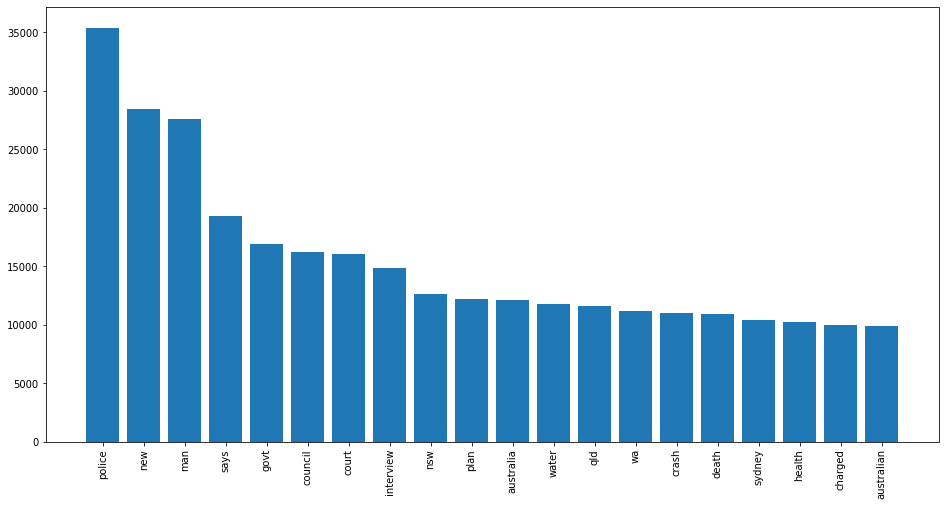

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');

Next we generate a histogram of headline word lengths, and use part-of-speech tagging to understand the types of words used across the corpus. This requires first converting all headline strings to TextBlobs and calling the pos_tags method on each, yielding a list of tagged words for each headline.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
! python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [ ]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = []
pos_counts = {}

for headlines in tagged_headlines_df['tags']:
    word_counts.append(len(headlines))
    for tag in headlines:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] +=1
        else:
            pos_counts[tag[1]] =1
print("Total Number Words",np.sum(word_counts))
print("Mean number of words per headline",np.mean(word_counts))

Total Number Words 6908893
Mean number of words per headline 6.384307242498392


In [ ]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

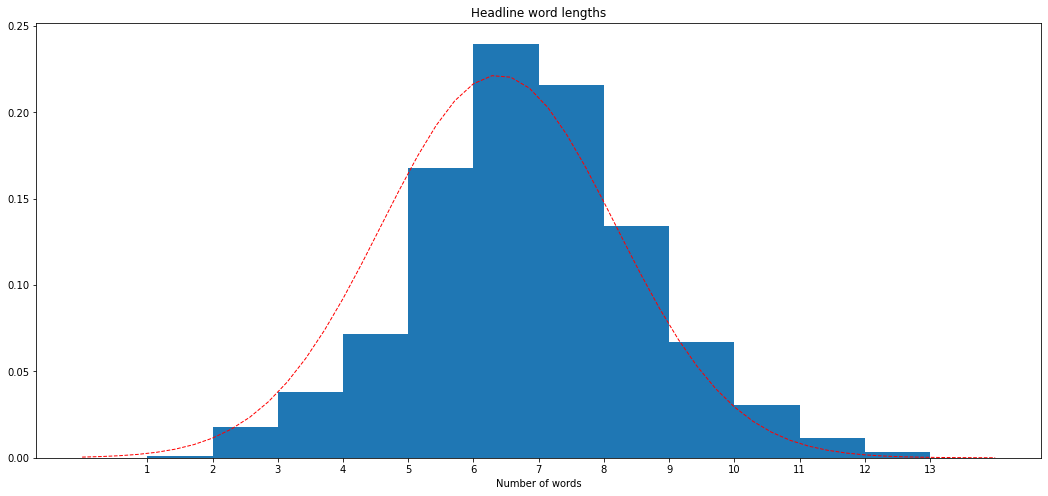

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

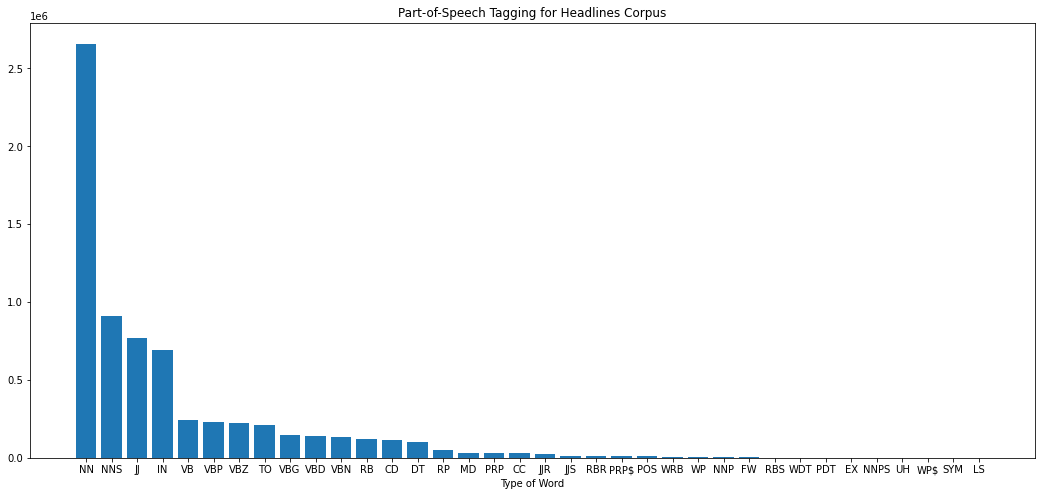

In [ ]:
pos_sorted_types  = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

In [ ]:
  monthly_counts  = reindexed_data.resample('M').count()
  yearly_counts  = reindexed_data.resample('A').count()
  daily_counts  = reindexed_data.resample('D').count()

Text(0.5, 1.0, 'yearly Count')

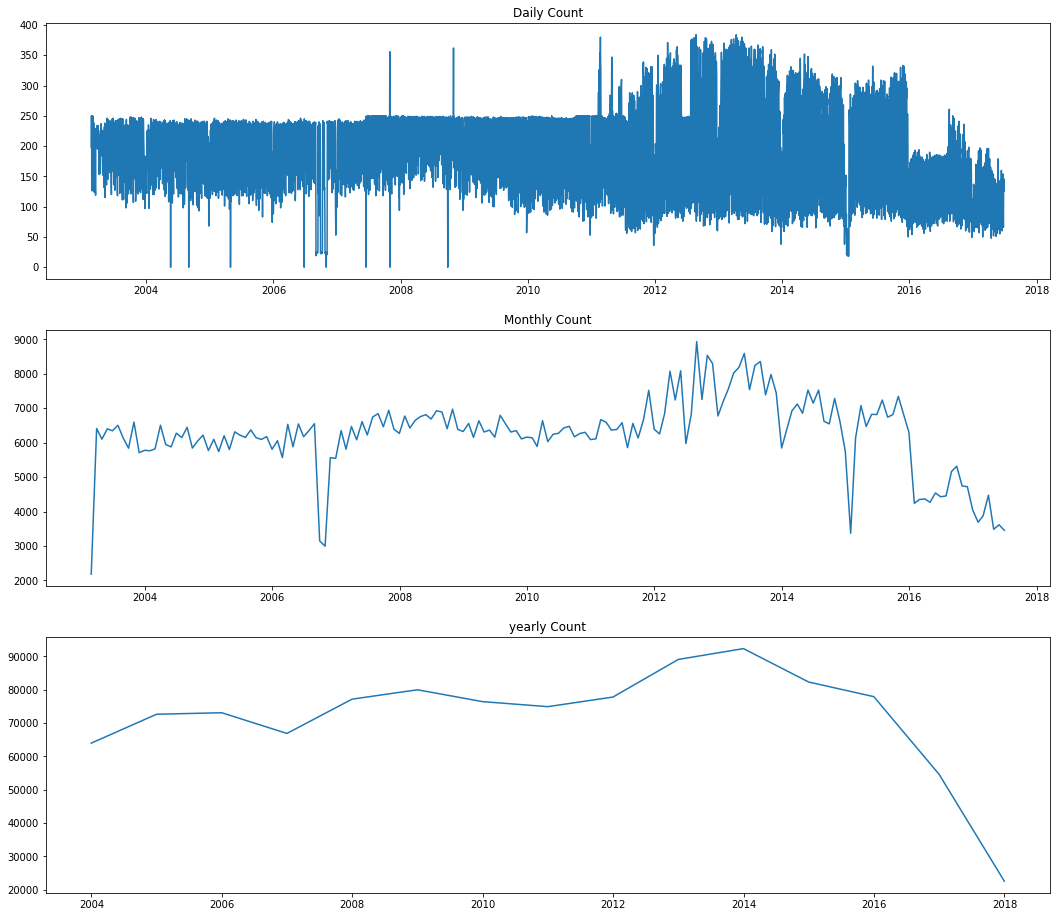

In [ ]:
fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts)
ax[0].set_title("Daily Count") 
ax[1].plot(monthly_counts)
ax[1].set_title("Monthly Count")
ax[2].plot(yearly_counts)
ax[2].set_title("yearly Count")

### Topic Modelling
We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we then scale up to a larger portion of the available data.

### Preprocessing
The only preprocessing step required in our case is feature construction, where we take the sample of text headlines and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the CountVectorizer object from SKLearn, which yields an  n×K  document-term matrix where  K  is the number of distinct words across the  n  headlines in our sample (less stop words and with a limit of max_features).

In [ ]:
small_count_vectorizer  = CountVectorizer(stop_words='english',max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

In [ ]:
small_text_sample

array(['labor attacks nationals mp over milk link',
       'coraki public school hip hop video', 'dairy record', ...,
       'joint strike fighters f35 land in australia',
       'greece secures unprecedented bailout',
       'fears red wine over supply may spark dumping'], dtype=object)

In [ ]:
print("Heading before vectorization: {}".format(small_text_sample[123]))

Heading before vectorization: spies cook up problem for al qaeda


In [ ]:
small_document_term_matrix  = small_count_vectorizer.fit_transform(small_text_sample)

In [ ]:
print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline after vectorization: 
  (0, 10425)	1
  (0, 2724)	1
  (0, 8630)	1
  (0, 577)	1
  (0, 8785)	1


Thus we have our (very high-rank and sparse) training data, small_document_term_matrix, and can now actually implement a clustering algorithm. Our choice will be either Latent Semantic Analysis or Latent Dirichilet Allocation. Both will take our document-term matrix as input and yield an  n×N  topic matrix as output, where  N  is the number of topic categories (which we supply as a parameter). For the moment, we shall take this to be 8.

In [ ]:
n_topics = 8

## Latent Semantic Analysis (truncated singular value decomposition)
* Let's start by experimenting with LSA
* This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the  r= n_topics largest singular values preserved.

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

Taking the  argmax  of each headline in this topic matrix will give the predicted topics of each headline in the sample. We can then sort these into counts of each topic.

In [ ]:
def get_keys(topic_matrix):
  '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
  keys = topic_matrix.argmax(axis=1).tolist()
  return keys

def keys_to_counts(keys):
  """return a tuple of topics categories and there  accompanying magnitudes for a given list of keys"""
  count_pairs = Counter(keys).items()
  categories = [pair[0] for pair in count_pairs]
  counts = [pair[1] for pair in count_pairs]
  return (categories, counts)   

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_keys[0:5]

[3, 4, 1, 3, 4]

In [ ]:
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
lsa_categories[0:5]

[3, 4, 1, 2, 0]

In [ ]:
lsa_counts[0:5]

[3549, 1367, 926, 644, 1495]

However, these topic categories are in and of themselves a little meaningless. In order to better characterise them, it will be helpful to find the most frequent words in each.

In [ ]:
def get_top_n_words(n,keys,document_term_matrix, count_vectorizer):

  top_word_indices = []
  for topic in range(n_topics):
    temp_vector_sum = 0
    for i in range(len(keys)):
      if keys[i] == topic:
        temp_vector_sum += document_term_matrix[i]
    temp_vector_sum = temp_vector_sum.toarray()
    top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
    top_word_indices.append(top_n_word_indices)   
    top_words = []
    
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(20, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  police death probe home missing attack car dead road melbourne fatal search killed wins hunt woman violence investigate hospital blaze


Thus we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

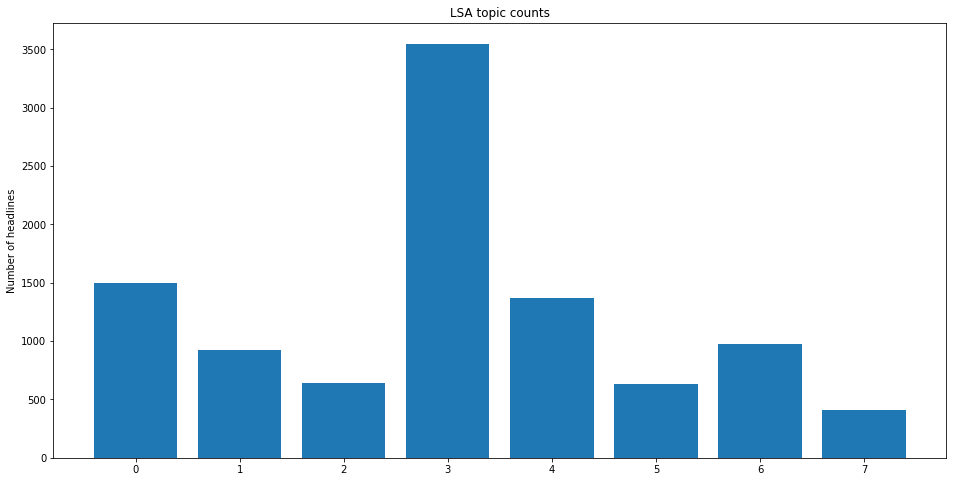

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys,small_document_term_matrix,small_count_vectorizer)
#labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig,ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories,lsa_counts)
ax.set_xticks(lsa_categories);
#ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

However, this does not provide a great point of comparison with other clustering algorithms. In order to properly contrast LSA with LDA we instead use a dimensionality-reduction technique called  t -SNE, which will also serve to better illuminate the success of the clustering process.

In [ ]:
tsne_lsa_model  = TSNE(n_components=2,perplexity=50,learning_rate=100,
                       n_iter=2000,verbose=1,random_state=0,angle=0.75)

In [ ]:
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
def get_mean_topic_vectors(keys,two_dim_vectors):
  mean_topic_vectors = []
  for t in range(n_topics):
    articles_in_that_topic = []
    for i in range(len(keys)):
      if keys[i] == t:
        articles_in_that_topic.append(two_dim_vectors[i])    
    articles_in_that_topic = np.vstack(articles_in_that_topic)
    mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
    mean_topic_vectors.append(mean_article_in_that_topic)
  return mean_topic_vectors

In [ ]:
top_3_words_lsa  = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

In [ ]:
plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0],
             y=tsne_lsa_vectors[:,1],
             color=colormap[lsa_keys])
for t in range(n_topics):
  label = Label(x=lsa_mean_topic_vectors[t][0],
                y=tsne_lsa_vectors[t][1],
                
                text_color=colormap[t])
  plot.add_layout(label)
  show(plot)